<a href="https://colab.research.google.com/github/Youhanna-Yousry/Tracking-Objects-in-Videos/blob/master/TrackingObjectsInVideos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [23]:
import requests
import os

import cv2
import numpy as np

from google.colab.patches import cv2_imshow
from google.colab import files

## Utilities

In [9]:
def download_file(file_url, file_name):
  video = requests.get(file_url).content
  with open(file_name, 'wb') as handler:
    handler.write(video)
  return os.path.join(os.getcwd(), file_name)

In [3]:
def print_video_info(video, video_name):
  h, w, frames_count = video.shape
  print(f'{video_name} info:')
  print(f'Width: {w}, Height: {h}, Number of Frames {frames_count}')

In [4]:
def get_video_frame(video, i):
  return video[:, :, i]

In [5]:
def draw_bounding_box(image, bounding_box, color=(0, 255, 0), thickness=2):
  x1, x2 = bounding_box[0]
  y1, y2 = bounding_box[1]
  image_bb = image.copy()
  image_bb = cv2.cvtColor(image_bb, cv2.COLOR_GRAY2BGR)
  cv2.rectangle(image_bb, (x1, y1), (x2, y2), color, thickness)
  return image_bb

In [6]:
def construct_video_from_frames(frames, video_name):
  h, w = frames[0].shape[:2]

  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  video = cv2.VideoWriter(video_name, fourcc, 25, (w, h))

  for frame in frames:
    video.write(frame)

  return os.path.join(os.getcwd(), video_name)

## Lucas-Kanade: Forward Additive Alignment

### 1. Downloading and Loading Videos

In [10]:
# downloading car2.npy and landing.npy  files
base_url = 'https://raw.githubusercontent.com/Youhanna-Yousry/Tracking-Objects-in-Videos/master/assets/'

car_file_name = "car2.npy"
car_file_path = download_file(base_url + car_file_name, car_file_name)

landing_file_name = "landing.npy"
landing_file_path = download_file(base_url + landing_file_name, landing_file_name)

In [11]:
# loading landing.npy and car2.npy files to numpy arrays
car_video = np.load('car2.npy')
landing_video = np.load('landing.npy')

In [12]:
# logging videos info
print_video_info(car_video, "Car Video")
print_video_info(landing_video, "Landing Video")

Car Video info:
Width: 320, Height: 240, Number of Frames 415
Landing Video info:
Width: 1100, Height: 1000, Number of Frames 50


### 2. Detecting First Frame Bounding Box

In [13]:
# loading first video frames
car_video_frame_1 = get_video_frame(car_video, 0)
landing_video_frame_1 = get_video_frame(landing_video, 0)

In [14]:
# manually detecting bounding box of desired objects in first frames
car_bounding_box = np.array([[47, 158], [105, 162]])
landing_bounding_box = np.array([[440, 555], [90, 130]])

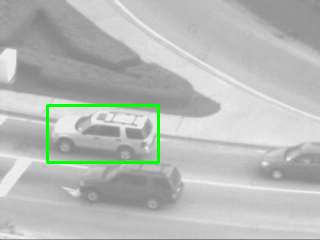

In [15]:
cv2_imshow(draw_bounding_box(car_video_frame_1, car_bounding_box))

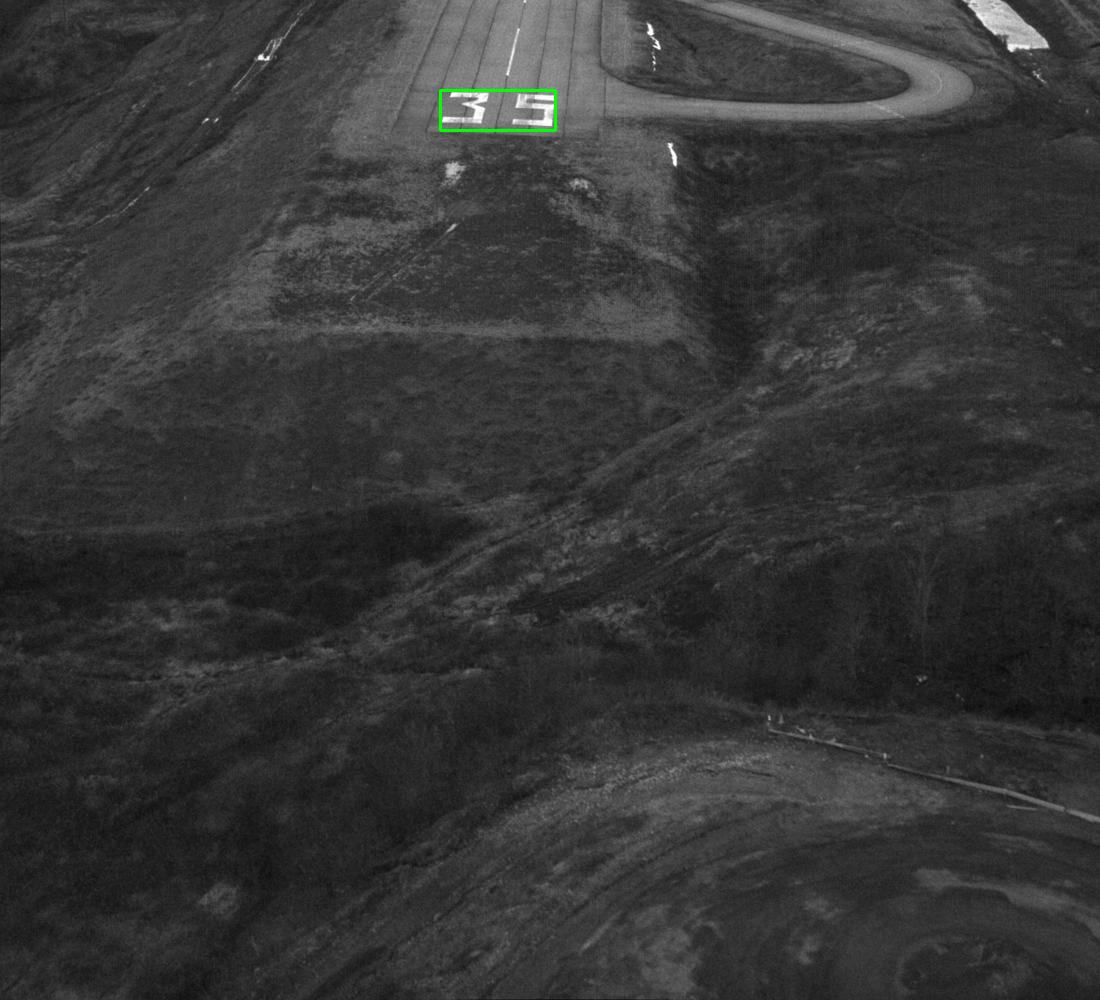

In [16]:
cv2_imshow(draw_bounding_box(landing_video_frame_1, landing_bounding_box))

### 3. Tracker Implementation

**Function to Enumerate Pixel Coordinates for ROI.**

  **Parameters:**
  1. `roi`: The Region of Interest defined by a 2x2 NumPy array, where each row corresponds to (y, x) coordinates.

  **Returns:**
  Two 1D NumPy arrays representing the enumerated x and y coordinates within the specified ROI.

In [17]:
def enumerating_coordinates(roi):
  """Enumerate the pixels coordinates for ROI"""

  x_coors = np.asarray(list(range(roi[0, 1], roi[1, 1])))
  y_coors = np.asarray(list(range(roi[0, 0], roi[1, 0])))

  x_coors, y_coors = np.meshgrid(x_coors, y_coors ,indexing='ij')

  return x_coors.flatten(), y_coors.flatten()

 **Function to Retrieve Pixel Intensities from an Image.**

  **Parameters:**
  1. `coordinates`: 2D NumPy array containing pixel coordinates.
  2. `img`: The image from which intensities are to be extracted.

  **Returns:**
  1D NumPy array representing the intensities corresponding to the provided pixel coordinates.

In [18]:
def get_intesities(coordinates, img):
  intensites = np.zeros((coordinates.shape[1], 1))

  intensites[:,0] = img[coordinates[1, :].astype(int), coordinates[0, :].astype(int)]

  return intensites

**Compute Steepest Descent Matrix for Lucas-Kanade Alignment Tracker.**

  **Parameters:**
  1. `IWx`: Image gradients along the x-axis.
  2. `IWy`: Image gradients along the y-axis.
  3. `coordinates`: 2D NumPy array containing pixel coordinates.

  **Returns:**
  2D NumPy array representing the steepest descent matrix for Lucas-Kanade

  **Steps** It computs vertically stacked Steepest Descent Matrix on shape [x*dIx, x*dIy, y*dIy, y*dIx, y*dIy, dIx, dIy]

In [19]:
def compute_steepest_decsent(IWx, IWy, coordinates):

  return np.column_stack((IWx[0,:] * coordinates[:,0], IWy[0,:] * coordinates[:,0], IWx[0,:] * coordinates[:,1], \
                   IWy[0,:] * coordinates[:,1], IWx[0,:], IWy[0,:]))

**Compute Optical Flow Parameters using Lucas-Kanade method.**

**Parameters:**
  1. `curr_frame`: Template in the video sequence.
  2. `next_frame`: Next frame in the video sequence.
  3. `p`: Initial guess for the warping parameters.
  4. `roi`: Region of Interest defined by a 2x2 NumPy array
  5. `threshold`: Convergence threshold for the optimization.
  6. `num_itr`: Maximum number of iterations for optimization.

**Returns:**
  Tuple containing the warped matrix (W) and the refined optical flow parameters (p).

**Steps**

    
    1. Initialize variables, including pixel coordinates within the ROI.
    2. Compute the image gradients (Ix and Iy) using Sobel operators.
    3. Perform iterative optimization to estimate the warping parameters:
        a. Update the warp matrix (W) based on the current parameters (p).
        b. Warp the coordinates using the warp matrix.
        c. Extract pixel intensities (T) from the template.
        d. Extract pixel intensities (I) from the next frame at the warped coordinates.
        e. Compute the error (E) between the intensities of the template and the frame.
        f. Compute steepest descent matrix (SD) based on image gradients and warped coordinates.
        g. Compute the Hessian matrix (H) using the steepest descent matrix.
        h. Update the warping parameters (p).
        i. Check convergence by evaluating the norm of the parameter update.
        j. Repeat until convergence or maximum iterations are reached.
      4. Return the warped matrix (W) and refined warping parameters (p).

In [20]:
def compute_p(curr_frame, next_frame, p, roi, threshold, num_itr):

    norm = np.inf

    x_coors, y_coors = enumerating_coordinates(roi)
    x = np.array([x_coors, y_coors, [1] * len(x_coors)]).T.astype(float)

    T = get_intesities(x.T, curr_frame).reshape(-1, 1).astype(float)

    Ix = cv2.Sobel(next_frame,cv2.CV_64F,1,0,ksize=3)
    Iy = cv2.Sobel(next_frame,cv2.CV_64F,0,1,ksize=3)

    itr = 0

    while norm > threshold and itr < num_itr:

        W =  np.array([[1+p[0], p[2], p[4]], [p[1], 1+p[3], p[5]]])

        x_dash = W @ x.T

        x_dash[0, :] = np.minimum(x_dash[0, :].astype(int), next_frame.shape[1] - 1)
        x_dash[1, :] = np.minimum(x_dash[1, :].astype(int), next_frame.shape[0] - 1)

        I = get_intesities(x_dash, next_frame).reshape(-1, 1).astype(float)

        E = T - I

        IWx = get_intesities(x_dash, Ix).reshape(-1, 1).astype(float)
        IWy = get_intesities(x_dash, Iy).reshape(-1, 1).astype(float)

        SD = compute_steepest_decsent(IWx.T, IWy.T, x)

        H = SD.T.dot(SD)

        dp = np.linalg.pinv(H).dot(SD.T.dot(E)).flatten()

        p = p + dp

        norm = np.linalg.norm(dp)

        itr = itr + 1

    return W,p

**Track Object in a Video using Lucas-Kanade Additive Alignmetn Tracker.**

**Parameters:**

  1. `video`: Video sequence represented as a NumPy array.
  2. `bounding_box`: Initial bounding box coordinates for the object to be tracked.
  3. `threshold`: Convergence threshold for warping parameters.
  4. `num_itr`: Maximum number of iterations.

**Returns:**

  NumPy array containing frames with tracked bounding boxes.

**Steps:**

  1. Initialize variables, including the default bounding box and iteration counter.
  2. Iterate through video frames:
       a. Compute the warping parameters using `compute_p` function.
       b. Warp the initial bounding box using the computed parameters.
       c. Draw the warped bounding box on the current frame.
       d. Append the frame with the tracked bounding box to the result.
       e. Update the iteration counter.
       f. Repeat until all frames are processed.
  3. Return the resulting array of frames with tracked bounding boxes.

In [21]:
def track_object(video, bounding_box, threshold=0.035, num_itr=150):

  video_bb = []
  i = 0
  frames_count = video.shape[2]

  default_bbox = np.array([[bounding_box[1,0], bounding_box[0,0]], [bounding_box[1,1], bounding_box[0,1]]])

  p = np.zeros(6)

  while True:

    if i == frames_count - 1:
      break

    W,p = compute_p(get_video_frame(video, 0).copy(), get_video_frame(video, i).copy(), p, default_bbox, threshold, num_itr)

    new_bounding_box = W.dot(np.vstack((bounding_box.copy(), [1,1])))

    new_bounding_box = np.rint(new_bounding_box).astype(int)
    frame_bb = draw_bounding_box(get_video_frame(video, i), new_bounding_box)
    video_bb.append(frame_bb)

    i = i + 1

  return np.array(video_bb)

In [22]:
car_video_bb = track_object(car_video, car_bounding_box)

In [24]:
car_video_bb_path = construct_video_from_frames(car_video_bb, "car_video_bb.mp4")

In [25]:
# run this cell to download the car video directly
files.download(car_video_bb_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
landing_video_bb = track_object(landing_video, landing_bounding_box)

In [27]:
landing_video_bb_path = construct_video_from_frames(landing_video_bb, "landing_video_bb.mp4")

In [28]:
# run this cell to download the landing video directly
files.download(landing_video_bb_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>